   width  length
0     66      21
1     63      34
2     49      22
3     50      33
4     59      24
5     51      20
6     62       7
7     73      30
8     58      33
9     26      20
Initial bin length is: 340
1th time coverage_ratio: 0.6138392857142857
2th time coverage_ratio: 0.6138392857142857
3th time coverage_ratio: 0.6138392857142857
4th time coverage_ratio: 0.6138392857142857
5th time coverage_ratio: 0.6740196078431373
6th time coverage_ratio: 0.6138392857142857
7th time coverage_ratio: 0.6138392857142857
8th time coverage_ratio: 0.6138392857142857
9th time coverage_ratio: 0.6138392857142857
10th time coverage_ratio: 0.6740196078431373


Press Enter to pack next item or type 'exit' to quit:  


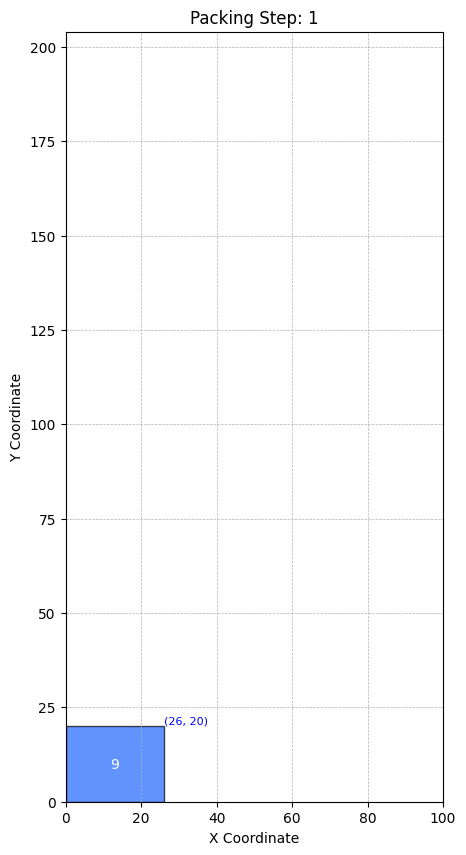

Press Enter to pack next item or type 'exit' to quit:  


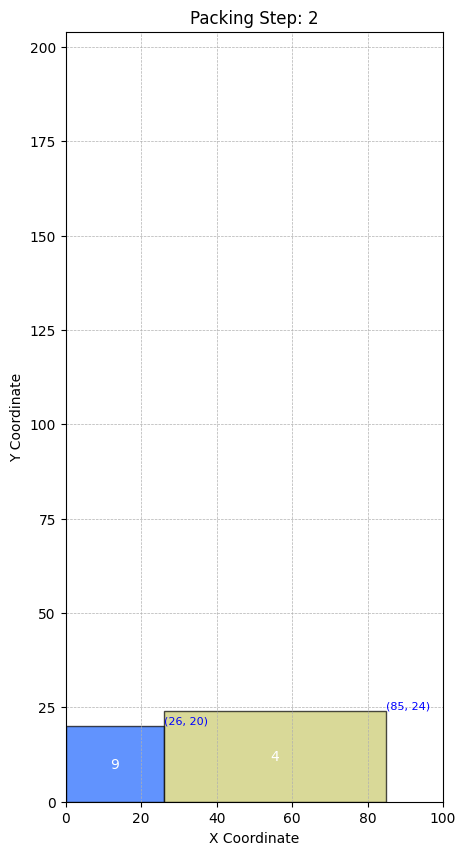

Press Enter to pack next item or type 'exit' to quit:  


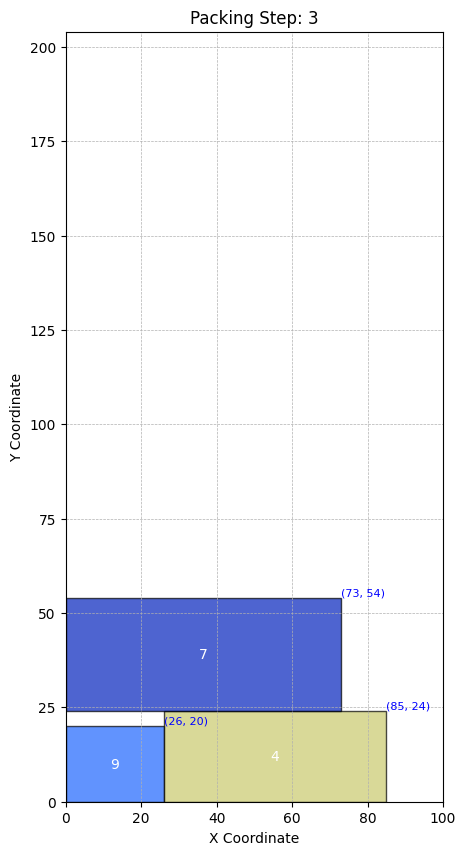

Press Enter to pack next item or type 'exit' to quit:  


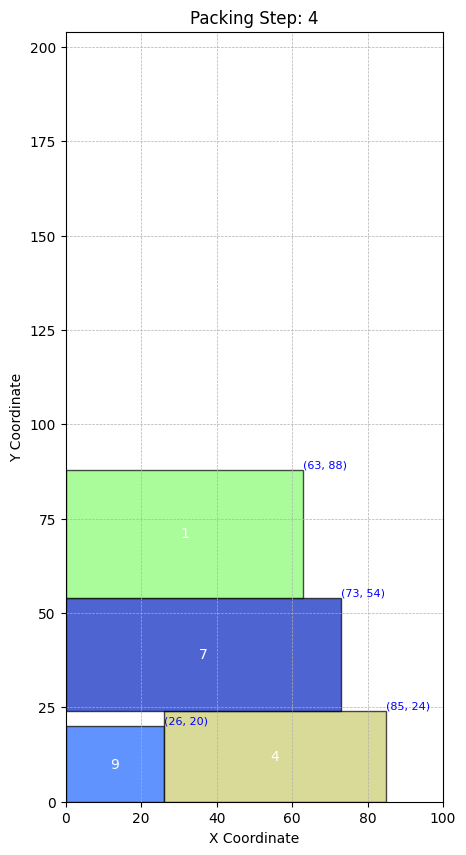

Press Enter to pack next item or type 'exit' to quit:  


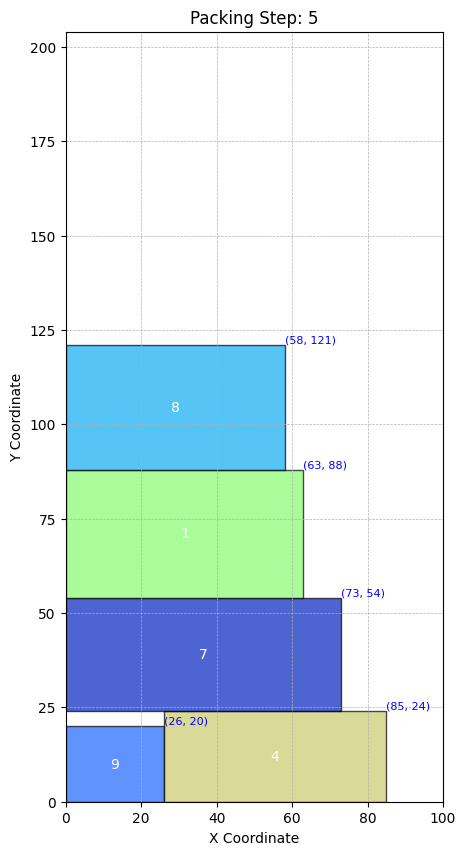

Press Enter to pack next item or type 'exit' to quit:  


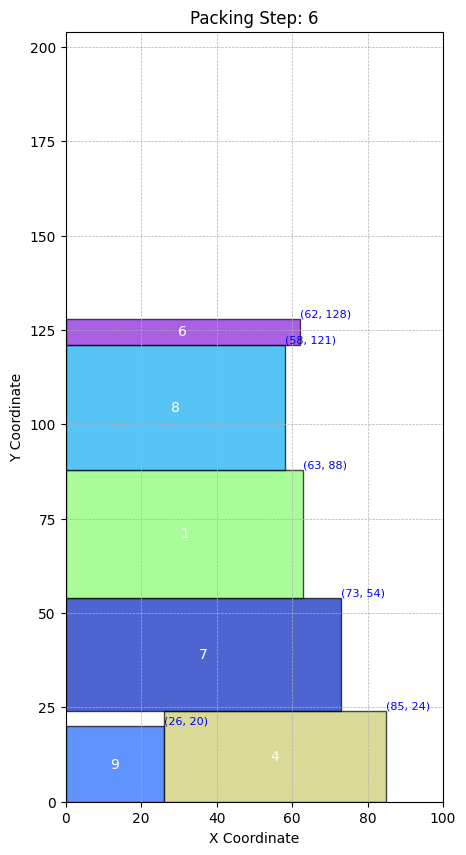

Press Enter to pack next item or type 'exit' to quit:  


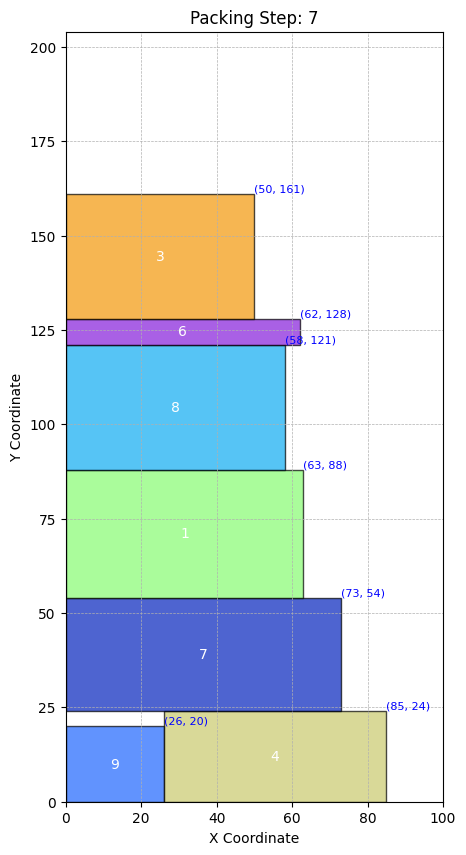

Press Enter to pack next item or type 'exit' to quit:  


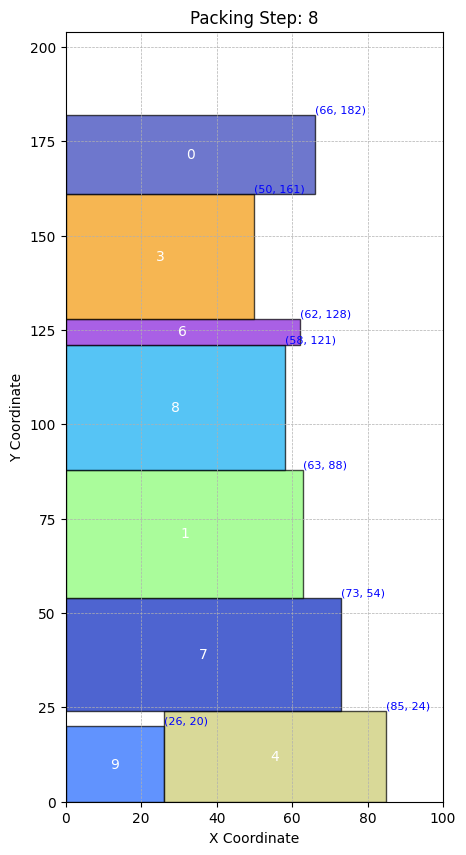

Press Enter to pack next item or type 'exit' to quit:  


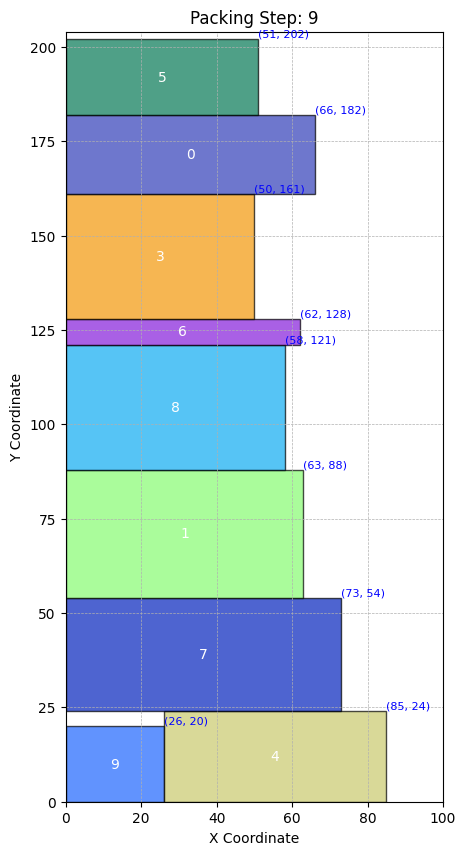

Press Enter to pack next item or type 'exit' to quit:  


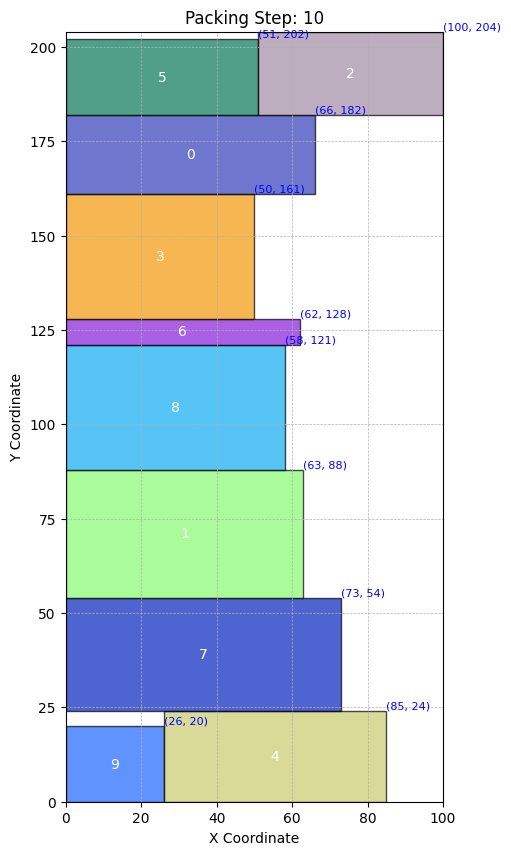

All items packed!	Coverage Ratio: 0.6740


In [41]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tools import *  # 假设overlap和finalPos函数已经在tools模块中定义

# 从文件中读取输入数据
def read_input_from_file(filename):
    with open(filename, 'r') as file:
        
        lines = file.readlines()

        # 提取给定的箱子宽度和矩形数量
        given_width = int(lines[0].split(':')[1].strip())  # 第一行是箱子的宽度
        number_of_rectangles = int(lines[1].split(':')[1].strip())  # 第二行是矩形的数量

        # 提取矩形的宽度和高度
        items = []
        for line in lines[3:]:  # 从第4行开始读取矩形数据
            width, height = map(int, line.strip().split())  # 每行包含矩形的宽和高
            items.append([width, height])  # 将矩形的宽高添加到列表中

        return given_width, number_of_rectangles, np.array(items)

# 读取输入文件
filename = 'test_size_10_dist_1.txt'
WIDTH, itemNum, AllItem = read_input_from_file(filename)

# 将物品转换为DataFrame格式
df_AllItem = pd.DataFrame(AllItem, columns=['width', 'length'])  # 将矩形的宽度和长度存储到DataFrame
print(df_AllItem)

LENGTH = max(AllItem[:, 1]) * itemNum  # 箱子长度是物品中最大的长度乘以物品数
Bin = [WIDTH, LENGTH]  # 设置箱子的宽度和长度
print(f"Initial bin length is: {LENGTH}")  # 打印箱子的初始长度

ansBXY = np.zeros((itemNum, 3))  # 用来存储装箱后的物品信息，格式为[箱子编号，X坐标，Y坐标]
RPNXY = []  # 用来存储物品的最终位置
BinNum = 1  # 初始箱子编号为1
flagItem = np.zeros(itemNum)  # 标记物品是否被装入箱子，0表示没有装入，1表示已装入
max_length = 0  # 初始化箱子最大长度

# 为每个物品生成一个随机颜色，用于后续的可视化
item_colors = {i: np.random.rand(3,) for i in range(itemNum)}  # 每个物品都分配一个随机颜色

# 开始装箱过程

def try_pack(bin_length):
    global RPNXY, flagItem, ansBXY, Bin, max_length
    max_length = 0  # 重置箱子的最大长度
    Bin = [WIDTH, bin_length]  # 设置箱子的宽度和长度
    RPNXY = []  # 清空已装入物品的位置记录
    flagItem = np.zeros(itemNum)  # 重置物品状态

    # 遍历每个物品，检查是否可以装入箱子
    for i in range(itemNum):
        if flagItem[ran[i]] == 0:  # 如果该物品还未装入箱子
            item = AllItem[ran[i], :]  # 获取物品的尺寸
            itemRP = Bin  # 初始位置设定在箱子的右上角
            flagOL = overlap(item, AllItem, itemRP, RPNXY)  # 检查物品是否与已装入的物品重叠
            if flagOL == 0:  # 如果没有重叠
                itemRP = finalPos(item, AllItem, itemRP, RPNXY)  # 计算物品的最终位置
                if len(itemRP) > 0:  # 如果找到了有效的位置
                    RPNXY.append([ran[i], itemRP[0], itemRP[1]])  # 保存物品的位置
                    flagItem[ran[i]] = 1  # 标记该物品已经装入
                    if itemRP[1] > max_length:  # 如果该物品的Y坐标大于当前最大长度，更新最大长度
                        max_length = itemRP[1]
    return all(flagItem)  # 如果所有物品都装入箱子，则返回True，否则返回False

# 计算覆盖率
def compute_coverage_ratio(packed_items, bin_width, bin_length):
    # 将已装入的物品与其位置合并
    packed_items = pd.DataFrame(packed_items, columns=['itemNum', 'X', 'Y'])
    packed_items = packed_items.merge(df_AllItem, left_on='itemNum', right_index=True)

    # 计算物品的总面积
    packed_items['area'] = packed_items['width'] * packed_items['length']
    total_area = packed_items['area'].sum()

    # 计算箱子的面积
    bin_area = bin_width * bin_length

    # 计算覆盖率
    coverage_ratio = total_area / bin_area
    return coverage_ratio


def try_pack_step(bin_length, current_step):
    global RPNXY, flagItem, ansBXY, Bin, max_length
    max_length = 0  # 重置箱子的最大长度
    Bin = [WIDTH, bin_length]  # 设置箱子的宽度和长度
    RPNXY = []  # 清空已装入物品的位置记录
    flagItem = np.zeros(itemNum)  # 重置物品状态

    step_counter = 0  # 初始化步骤计数器
    # 遍历每个物品，按步骤装入箱子
    for i in range(itemNum):
        if flagItem[ran[i]] == 0:  # 如果该物品还未装入箱子
            item = AllItem[ran[i], :]  # 获取物品的尺寸
            itemRP = Bin  # 初始位置设定在箱子的右上角
            flagOL = overlap(item, AllItem, itemRP, RPNXY)  # 检查物品是否与已装入的物品重叠
            if flagOL == 0:  # 如果没有重叠
                itemRP = finalPos(item, AllItem, itemRP, RPNXY)  # 计算物品的最终位置
                if len(itemRP) > 0:  # 如果找到了有效的位置
                    RPNXY.append([ran[i], itemRP[0], itemRP[1]])  # 保存物品的位置
                    flagItem[ran[i]] = 1  # 标记该物品已经装入
                    if itemRP[1] > max_length:  # 如果该物品的Y坐标大于当前最大长度，更新最大长度
                        max_length = itemRP[1]
                    
                    step_counter += 1  # 更新步骤计数
                    if step_counter == current_step:  # 如果到达当前步骤，则停止
                        return False  # 停止当前步骤
    return all(flagItem)  # 如果所有物品都装入箱子，则返回True，否则返回False

def visualize_packing_step(packed_items, bin_width, bin_length, all_items, current_step):
    """
    可视化装箱过程中的每一步，展示每个物品的装入状态。

    参数:
    - packed_items: 已装入物品的列表，包含[itemNum, X, Y]。
    - bin_width: 箱子的宽度。
    - bin_length: 箱子的长度。
    - all_items: 包含所有物品的尺寸信息的DataFrame。
    - current_step: 当前的装箱步骤。
    """
    # 创建图表
    fig, ax = plt.subplots(figsize=(10, 10))

    # 绘制箱子的边界
    ax.set_xlim(0, bin_width)
    ax.set_ylim(0, bin_length)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f'Packing Step: {current_step}')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    # 添加网格线，提高可视化效果
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # 绘制当前步骤装入的物品
    for idx, packed_item in enumerate(packed_items):
        if idx >= current_step:  # 如果超过当前步骤，则停止绘制
            break
        itemNum, X, Y = packed_item
        width, length = all_items.loc[itemNum, ['width', 'length']]

        # 矩形的左下角坐标
        bottom_left_x = X - width
        bottom_left_y = Y - length

        # 创建矩形并赋予每个物品独特的颜色
        rect = patches.Rectangle(
            (bottom_left_x, bottom_left_y),  # 左下角坐标
            width,
            length,
            linewidth=1,
            edgecolor='black',
            facecolor=item_colors[itemNum],  # 使用之前为每个物品指定的颜色
            alpha=0.7
        )
        ax.add_patch(rect)

        # 添加文本注释，显示物品的尺寸和坐标
        ax.text(X - width / 2, Y - length / 2, f'{itemNum}', color='white', ha='center', va='center', fontsize=10)
        ax.text(X, Y, f'({X}, {Y})', color='blue', fontsize=8, ha='left', va='bottom')

    # 设置坐标轴范围并显示图表
    ax.set_xlim(0, bin_width)
    ax.set_ylim(0, bin_length)
    plt.savefig(f'Visualization_for_steps_image/Step{idx}.png')
    plt.show()

# 主循环：尝试进行多次装箱操作，获取最大覆盖率
max_coverage_ratio = 0
for i in range (1, 11):
    ran = list(range(itemNum))
    random.shuffle(ran)  # 随机生成装箱顺序
    if try_pack(LENGTH):
        coverage_ratio = compute_coverage_ratio(RPNXY, WIDTH, max_length)
        print(f"{i}th time coverage_ratio: {coverage_ratio}")
        if coverage_ratio > max_coverage_ratio:  # 如果当前覆盖率比最大值还高，则更新
            max_coverage_ratio = coverage_ratio
            final_length = max_length
            final_RPNXY = RPNXY

# 逐步显示装箱过程
current_step = 1
while not try_pack_step(LENGTH, current_step):
    user_input = input("Press Enter to pack next item or type 'exit' to quit: ")
    if user_input.lower() == 'exit':
        break

    visualize_packing_step(final_RPNXY, WIDTH, final_length, df_AllItem, current_step)
    current_step += 1

# 打印最终的覆盖率
coverage_ratio = compute_coverage_ratio(final_RPNXY, WIDTH, final_length)
print(f"All items packed!\tCoverage Ratio: {coverage_ratio:.4f}")  # 打印最终的覆盖率
